In [1]:
import pandas as pd
from google.cloud import bigquery
from datetime import datetime, timedelta
import joblib
import numpy as np

In [2]:
# project_id = "banded-setting-428309-q4"
# dataset_id = "datos"

In [3]:
# client = bigquery.Client(project='banded-setting-428309-q4')
# one_week_ago = datetime.now() - timedelta(days=7)
    
# query = f"""
# SELECT
#     FORMAT_TIMESTAMP('%Y-%m-%d', Timestamp) AS Day,
#     FORMAT_TIMESTAMP('%H', Timestamp) AS Hour,
#     FORMAT_TIMESTAMP('%M', Timestamp) AS Minute,
#     ct.descripcion,
#     bd.Value
# FROM `banded-setting-428309-q4.datos.bronze-data` bd
# LEFT JOIN `banded-setting-428309-q4.datos.col-tag` ct on bd.Tag = ct.tag
# WHERE DATE(Timestamp) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 50 DAY) AND CURRENT_DATE()
# """

# query_job = client.query(query)
# results = query_job.result()

# data = []   
# for row in results:     
#     data.append(dict(row))
    
# df = pd.DataFrame(data)

In [4]:
# df.head()

In [5]:
# df.to_parquet('140_days_df.parquet')

In [6]:
df = pd.read_parquet('140_days_df.parquet')

In [7]:
df_max_values = df.groupby(["descripcion", "Day", "Hour", "Minute"]).agg({"Value": "max"}).reset_index()

df_max_values['dayhourminute'] = df_max_values['Day'] + ' ' + df_max_values['Hour'] + ':' + df_max_values['Minute']
df_unpivot = df_max_values.pivot_table(index="dayhourminute", columns="descripcion", values="Value", aggfunc="max").reset_index()

In [8]:
df_unpivot

descripcion,dayhourminute,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% REG. VF BOMBA ALIMENT. SWENSON,% VAR. BOMBA SDA. CUBETA CH,% VARIADOR BOMBA ALIM. C.V.,% VF BOMBA ALIMENTACION W7,% VF BOMBA SALIDA SWENSON A CCHH,...,VOL RECUPERACION ANION GRUPO H0,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A EDAR,VOLUMEN CIP A PEQUEÑAS AGUAS,VOLUMEN CIP LAVADO AGUA,VOLUMEN LAVADO CIP,VÁLVULA REGULADORA NIVEL M10,W10 STATUS,W7 STATUS
0,2024-06-09 00:00,0.000000,NaN,852.856995,9697.578125,NaN,NaN,51.768593,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-09 00:01,11.125526,NaN,1051.594116,10000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-06-09 00:02,24.037436,NaN,1047.765991,9903.143555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-06-09 00:03,27.494791,NaN,979.953308,10000.000000,60.657055,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-09 00:04,46.029263,NaN,899.699402,10000.000000,NaN,54.669937,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18212,2024-06-21 15:48,0.000000,NaN,NaN,NaN,NaN,14.933886,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18213,2024-06-21 15:49,NaN,NaN,NaN,0.000000,NaN,16.333483,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18214,2024-06-21 15:50,11.963161,NaN,NaN,4456.027344,NaN,15.153301,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18215,2024-06-21 15:51,20.796946,NaN,NaN,4819.892578,NaN,18.225300,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
columns_to_check = [
    "COR TITÁNIC AZÚCARES", 
    "COT TITÁNIC AZÚCARES NUEVO", 
    "COT AGUAS ÁCIDAS", 
    "COT AGUAS ÁCIDAS NUEVO"
]

conditions = pd.Series([False] * len(df_unpivot))
for col in columns_to_check:
    if col in df_unpivot.columns:
        conditions |= (df_unpivot[col] > 2500)

df_unpivot["flag"] = conditions.astype(int)

df_unpivot["dayhourminute"] = pd.to_datetime(df_unpivot["dayhourminute"])

df_unpivot.head()


descripcion,dayhourminute,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% REG. VF BOMBA ALIMENT. SWENSON,% VAR. BOMBA SDA. CUBETA CH,% VARIADOR BOMBA ALIM. C.V.,% VF BOMBA ALIMENTACION W7,% VF BOMBA SALIDA SWENSON A CCHH,...,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A EDAR,VOLUMEN CIP A PEQUEÑAS AGUAS,VOLUMEN CIP LAVADO AGUA,VOLUMEN LAVADO CIP,VÁLVULA REGULADORA NIVEL M10,W10 STATUS,W7 STATUS,flag
0,2024-06-09 00:00:00,0.000000,NaN,852.856995,9697.578125,NaN,NaN,51.768593,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2024-06-09 00:01:00,11.125526,NaN,1051.594116,10000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2024-06-09 00:02:00,24.037436,NaN,1047.765991,9903.143555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2024-06-09 00:03:00,27.494791,NaN,979.953308,10000.000000,60.657055,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2024-06-09 00:04:00,46.029263,NaN,899.699402,10000.000000,NaN,54.669937,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [10]:
col_drop = ['COT AGUAS ÁCIDAS NUEVO', 'COT AGUAS ÁCIDAS', 'COR TITÁNIC AZÚCARES', 'COT TITÁNIC AZÚCARES NUEVO','dayhourminute']  
df = df_unpivot.drop(columns=[col for col in col_drop if col in df_unpivot.columns])

In [11]:
df = df.fillna(method='ffill').fillna(0)

C:\Users\Pacotm\AppData\Local\Temp\ipykernel_1756\3594675012.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


In [12]:
exclude_columns = ['flag']
df_corr = df.drop(columns=exclude_columns).corr().abs()

upper_triangle_mask = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

drop_columns = set()

for column in upper_triangle_mask.columns:
    high_corr = upper_triangle_mask[column][(upper_triangle_mask[column] > 0.8) & (upper_triangle_mask[column] < 1)]
    if not high_corr.empty:
        drop_columns.add(column)

df = df.drop(columns=list(drop_columns))

In [13]:
with open('dropped_columns.txt', 'w') as f:
    for item in drop_columns:
        f.write("%s\n" % item)

In [14]:
# one_hour_earlier = df_unpivot["dayhourminute"] - pd.Timedelta(hours=1)
# df_unpivot["flag"] |= df_unpivot["dayhourminute"].isin(one_hour_earlier[conditions])

# df_unpivot["flag"] = df_unpivot["flag"].astype(int)

# df_unpivot.head()

In [15]:
df

descripcion,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% REG. VF BOMBA ALIMENT. SWENSON,% VAR. BOMBA SDA. CUBETA CH,% VARIADOR BOMBA ALIM. C.V.,% VF BOMBA ALIMENTACION W7,% VF BOMBA SALIDA SWENSON A CCHH,BOMBA RECUPERACIÓN GRUPOS H0,...,VLV REG NIVEL CUBA SDA D.C.,VLV REG NIVEL FLASH SDA D.C.,VOL RECUP ANION GRUPOS GLUC,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A PEQUEÑAS AGUAS,VOLUMEN CIP LAVADO AGUA,VOLUMEN LAVADO CIP,VÁLVULA REGULADORA NIVEL M10,flag
0,0.000000,0.0,852.856995,9697.578125,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,54.422516,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,11.125526,0.0,1051.594116,10000.000000,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,53.573341,27.017218,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,24.037436,0.0,1047.765991,9903.143555,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,51.552559,25.940605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,27.494791,0.0,979.953308,10000.000000,60.657055,0.000000,51.768593,0.0,0.000000,0.0,...,51.552559,27.621260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,46.029263,0.0,899.699402,10000.000000,60.657055,54.669937,51.768593,0.0,0.000000,0.0,...,45.102158,27.936863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18212,0.000000,0.0,10000.000000,9115.012695,59.912788,14.933886,0.100000,0.0,59.556168,0.0,...,25.252186,21.817596,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,0
18213,0.000000,0.0,10000.000000,0.000000,59.912788,16.333483,0.100000,0.0,59.556168,0.0,...,25.252186,21.817596,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,0
18214,11.963161,0.0,10000.000000,4456.027344,59.912788,15.153301,0.100000,0.0,59.556168,0.0,...,25.252186,23.262724,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,0
18215,20.796946,0.0,10000.000000,4819.892578,59.912788,18.225300,0.100000,0.0,59.556168,0.0,...,24.628326,20.543182,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,0


In [16]:
X = df.drop('flag', axis=1)
X = X.fillna(0)
X.head()

descripcion,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% REG. VF BOMBA ALIMENT. SWENSON,% VAR. BOMBA SDA. CUBETA CH,% VARIADOR BOMBA ALIM. C.V.,% VF BOMBA ALIMENTACION W7,% VF BOMBA SALIDA SWENSON A CCHH,BOMBA RECUPERACIÓN GRUPOS H0,...,VLV REG NIVEL CUBA NODRIZA,VLV REG NIVEL CUBA SDA D.C.,VLV REG NIVEL FLASH SDA D.C.,VOL RECUP ANION GRUPOS GLUC,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A PEQUEÑAS AGUAS,VOLUMEN CIP LAVADO AGUA,VOLUMEN LAVADO CIP,VÁLVULA REGULADORA NIVEL M10
0,0.000000,0.0,852.856995,9697.578125,0.000000,0.000000,51.768593,0.0,0.0,0.0,...,0.000000,54.422516,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.125526,0.0,1051.594116,10000.000000,0.000000,0.000000,51.768593,0.0,0.0,0.0,...,0.000000,53.573341,27.017218,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24.037436,0.0,1047.765991,9903.143555,0.000000,0.000000,51.768593,0.0,0.0,0.0,...,11.431318,51.552559,25.940605,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.494791,0.0,979.953308,10000.000000,60.657055,0.000000,51.768593,0.0,0.0,0.0,...,10.341727,51.552559,27.621260,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.029263,0.0,899.699402,10000.000000,60.657055,54.669937,51.768593,0.0,0.0,0.0,...,10.341727,45.102158,27.936863,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y = df['flag']
y.value_counts()

flag
0    15464
1     2753
Name: count, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(oob_score=True, random_state=42)

param_grid = {
    'n_estimators': [200]  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_


oob_score = best_model.oob_score_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'OOB Score: {oob_score:.4f}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)


Best Parameters: {'n_estimators': 200}
OOB Score: 0.9288
Accuracy: 0.9333150384193194
Confusion Matrix:
[[2960  142]
 [ 101  441]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3102
           1       0.76      0.81      0.78       542

    accuracy                           0.93      3644
   macro avg       0.86      0.88      0.87      3644
weighted avg       0.94      0.93      0.93      3644



In [20]:
import joblib
model_filename = 'rf_model.pkl'
joblib.dump(best_model, model_filename)
print(f'Model saved as {model_filename}')

Model saved as rf_model.pkl


In [21]:
sclaer_filename = 'scaler_model.pkl'
joblib.dump(scaler, sclaer_filename)
print(f'Scaler saved as {sclaer_filename}')

Scaler saved as scaler_model.pkl


# CHECK

## COEFFICIENTS

In [22]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train_scaled.shape[1])]

top_20_indices = np.argsort(feature_importances)[-20:]

print("Top 20 feature importances:")
for idx in reversed(top_20_indices):
    print(f'Feature {feature_names[idx]}: {feature_importances[idx]}')

Top 20 feature importances:
Feature NIVEL NUEVO CISTERNA 19 GLUCOSA: 0.015720134781383812
Feature NIVEL Nº1 TORTA P45 GLUCOSA: 0.01287247076733707
Feature NIVEL G4: 0.012652663932306487
Feature PRESION ENTRADA FILT GAF SDA W8: 0.011473318125307694
Feature NIVEL CUBA ENZIMATICA Nº11: 0.011252602427314478
Feature NIVEL CUBA SOSA DILUIDA: 0.010480025900449465
Feature NIVEL CISTERNA GLUCOSA Nº19: 0.010367581045509604
Feature PRESION DIFERENCIAL FILT W-9: 0.010330527957485604
Feature PRESION FILTRO NIAGRA Nº2 H0: 0.009840924224881696
Feature NIVEL CUBA C5: 0.00979549307787875
Feature NIVEL ANIÓN GRUPO 7: 0.00941964426641163
Feature PRESION DIFERENCIAL FILT GAF W7: 0.009248786546013856
Feature NIVEL CRISTALIZADOR HORIZONTAL 4: 0.008955143315771496
Feature PRESION SALIDA FILTRO GAF W10: 0.008870371860275549
Feature PRESION DIF FILTRO TRANSP DX: 0.008830570236193071
Feature PRESION DIFERENCIAL FILT GAF W10: 0.008694475799265728
Feature NIVEL 1 TORTA P45 H0: 0.008671570304078892
Feature NIVEL B

## CORRECT OBSERVATIONS

In [23]:
X_scaled = scaler.transform(X)

df['predicted'] = best_model.predict(X_scaled) 

df['flag'] = df['predicted'] == df[y_test.name]
correct_predictions = df['flag'].sum()

print(f'Number of correctly predicted rows: {correct_predictions}')

total_predictions = len(df)
percentage_correct = (correct_predictions / total_predictions) * 100

print(f'Percentage of correctly predicted rows: {percentage_correct:.2f}%')

Number of correctly predicted rows: 17974
Percentage of correctly predicted rows: 98.67%


In [24]:
correct_predictions_0 = df[df['predicted'] == 0]['flag'].sum()
total_predictions_0 = df[df['predicted'] == 0].shape[0]
percentage_correct_0 = (correct_predictions_0 / total_predictions_0) * 100 if total_predictions_0 > 0 else 0

correct_predictions_1 = df[df['predicted'] == 1]['flag'].sum()
total_predictions_1 = df[df['predicted'] == 1].shape[0]
percentage_correct_1 = (correct_predictions_1 / total_predictions_1) * 100 if total_predictions_1 > 0 else 0

print(f'Percentage of correctly predicted 0s: {percentage_correct_0:.2f}%')
print(f'Percentage of correctly predicted 1s: {percentage_correct_1:.2f}%')

Percentage of correctly predicted 0s: 99.35%
Percentage of correctly predicted 1s: 94.92%


In [25]:
df

descripcion,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% REG. VF BOMBA ALIMENT. SWENSON,% VAR. BOMBA SDA. CUBETA CH,% VARIADOR BOMBA ALIM. C.V.,% VF BOMBA ALIMENTACION W7,% VF BOMBA SALIDA SWENSON A CCHH,BOMBA RECUPERACIÓN GRUPOS H0,...,VLV REG NIVEL FLASH SDA D.C.,VOL RECUP ANION GRUPOS GLUC,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A PEQUEÑAS AGUAS,VOLUMEN CIP LAVADO AGUA,VOLUMEN LAVADO CIP,VÁLVULA REGULADORA NIVEL M10,flag,predicted
0,0.000000,0.0,852.856995,9697.578125,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,0
1,11.125526,0.0,1051.594116,10000.000000,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,27.017218,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,24.037436,0.0,1047.765991,9903.143555,0.000000,0.000000,51.768593,0.0,0.000000,0.0,...,25.940605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,0
3,27.494791,0.0,979.953308,10000.000000,60.657055,0.000000,51.768593,0.0,0.000000,0.0,...,27.621260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,0
4,46.029263,0.0,899.699402,10000.000000,60.657055,54.669937,51.768593,0.0,0.000000,0.0,...,27.936863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18212,0.000000,0.0,10000.000000,9115.012695,59.912788,14.933886,0.100000,0.0,59.556168,0.0,...,21.817596,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,True,0
18213,0.000000,0.0,10000.000000,0.000000,59.912788,16.333483,0.100000,0.0,59.556168,0.0,...,21.817596,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,True,0
18214,11.963161,0.0,10000.000000,4456.027344,59.912788,15.153301,0.100000,0.0,59.556168,0.0,...,23.262724,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,True,0
18215,20.796946,0.0,10000.000000,4819.892578,59.912788,18.225300,0.100000,0.0,59.556168,0.0,...,20.543182,12.027593,0.0,0.0,0.0,0.0,0.0,100.0,True,0


# METRICS

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

ROC AUC: 0.88


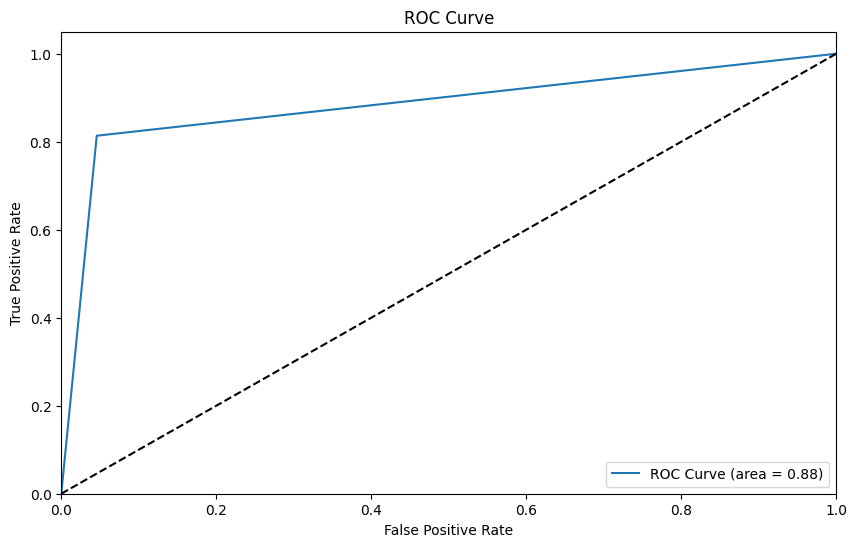

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

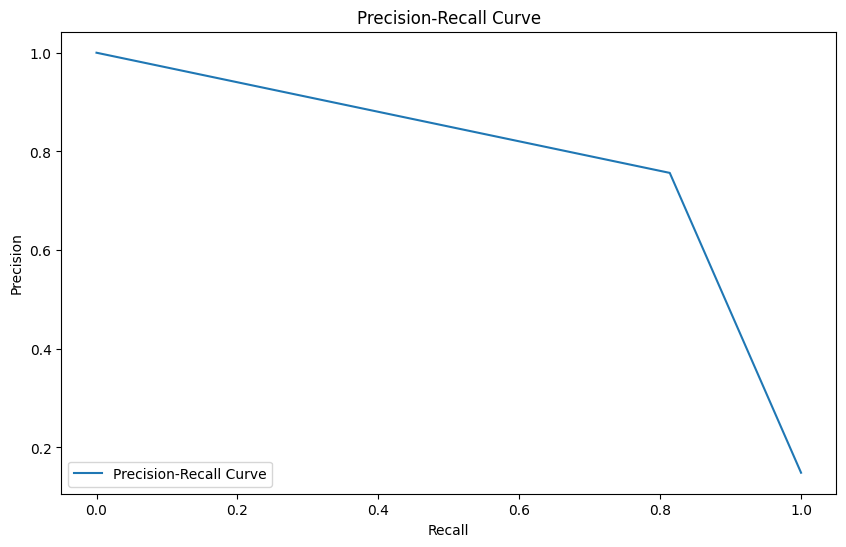

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [29]:
from sklearn.ensemble import RandomForestClassifier

print(f'OOB Score: {best_model.oob_score_:.4f}')


OOB Score: 0.9288


c:\Users\Pacotm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Pacotm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


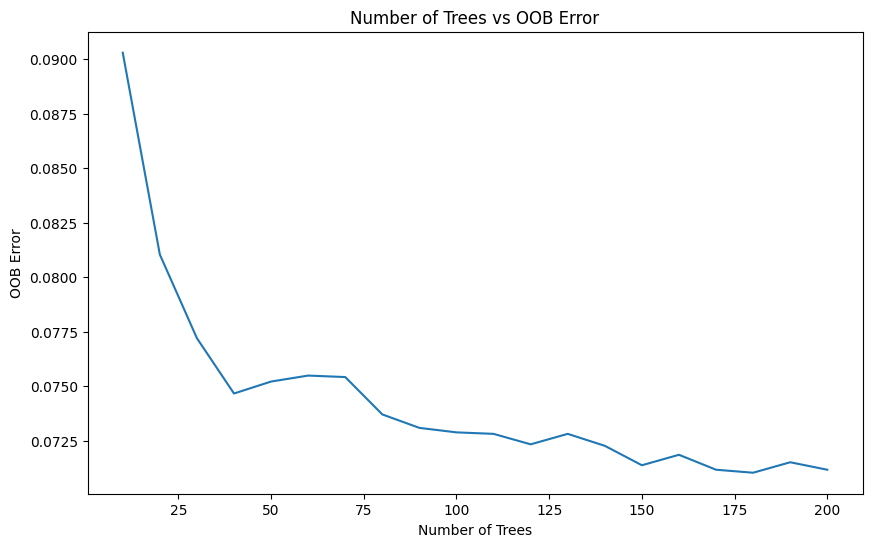

In [30]:
errors = []
n_trees = range(10, 201, 10)

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True)
    model.fit(X_train_scaled, y_train)
    errors.append(1 - model.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(n_trees, errors)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('Number of Trees vs OOB Error')
plt.show()


# OTHER MODELS + METRICS


# SVM

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [32]:
svm_model = SVC()

param_grid_svm = {
    'C': [0.1, 1],  
    'kernel': ['linear', 'rbf']
}


grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring='accuracy')


grid_search_svm.fit(X_train_scaled, y_train)
best_svm_model = grid_search_svm.best_estimator_


y_pred_svm = best_svm_model.predict(X_test_scaled)


accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)


print(f'Best Parameters (SVM): {grid_search_svm.best_params_}')
print(f'Accuracy (SVM): {accuracy_svm}')
print('Confusion Matrix (SVM):')
print(cm_svm)
print('Classification Report (SVM):')
print(report_svm)


Best Parameters (SVM): {'C': 1, 'kernel': 'rbf'}
Accuracy (SVM): 0.9119099890230515
Confusion Matrix (SVM):
[[3007   95]
 [ 226  316]]
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3102
           1       0.77      0.58      0.66       542

    accuracy                           0.91      3644
   macro avg       0.85      0.78      0.81      3644
weighted avg       0.91      0.91      0.91      3644



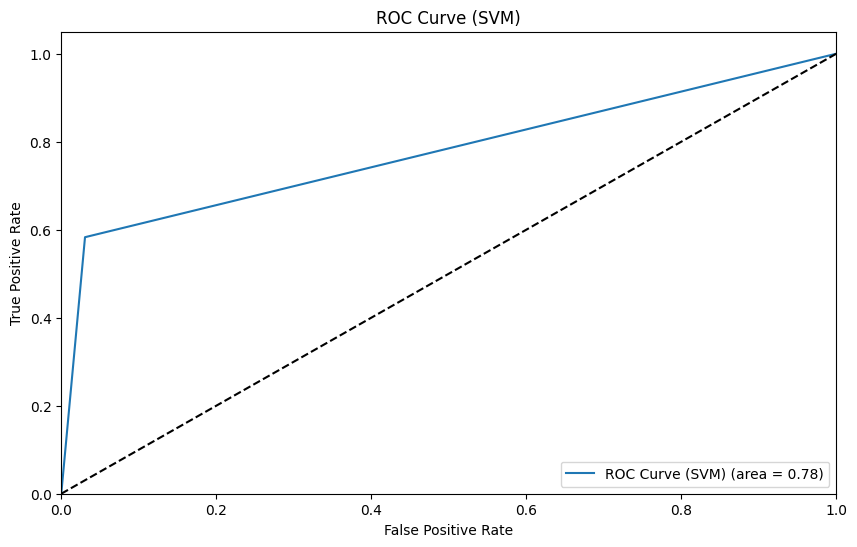

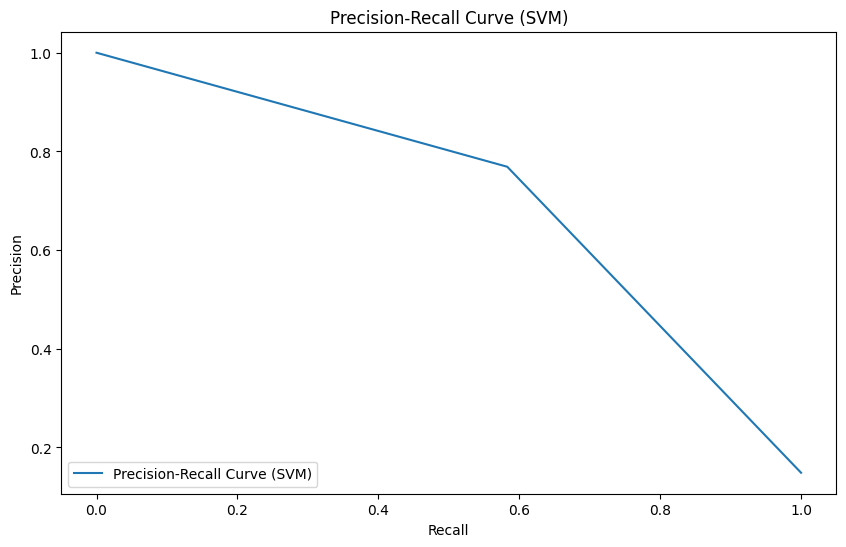

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Curva ROC
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, label=f'ROC Curve (SVM) (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

# Curva Precision-Recall
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)

plt.figure(figsize=(10, 6))
plt.plot(recall_svm, precision_svm, label='Precision-Recall Curve (SVM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SVM)')
plt.legend(loc="lower left")
plt.show()


# LINEAR REGRESSION

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np


In [35]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)


y_pred_linear = linear_model.predict(X_test_scaled)

y_pred_binary = np.where(y_pred_linear >= 0.5, 1, 0)

accuracy_linear = accuracy_score(y_test, y_pred_binary)
cm_linear = confusion_matrix(y_test, y_pred_binary)
report_linear = classification_report(y_test, y_pred_binary)


print(f'Accuracy (Regresión Lineal): {accuracy_linear}')
print('Confusion Matrix (Regresión Lineal):')
print(cm_linear)
print('Classification Report (Regresión Lineal):')
print(report_linear)


Accuracy (Regresión Lineal): 0.8844676180021954
Confusion Matrix (Regresión Lineal):
[[3018   84]
 [ 337  205]]
Classification Report (Regresión Lineal):
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3102
           1       0.71      0.38      0.49       542

    accuracy                           0.88      3644
   macro avg       0.80      0.68      0.71      3644
weighted avg       0.87      0.88      0.87      3644



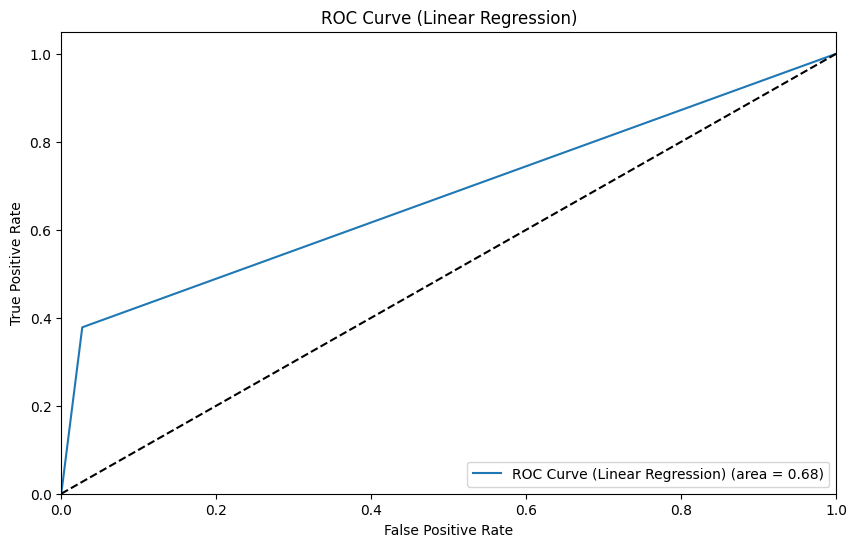

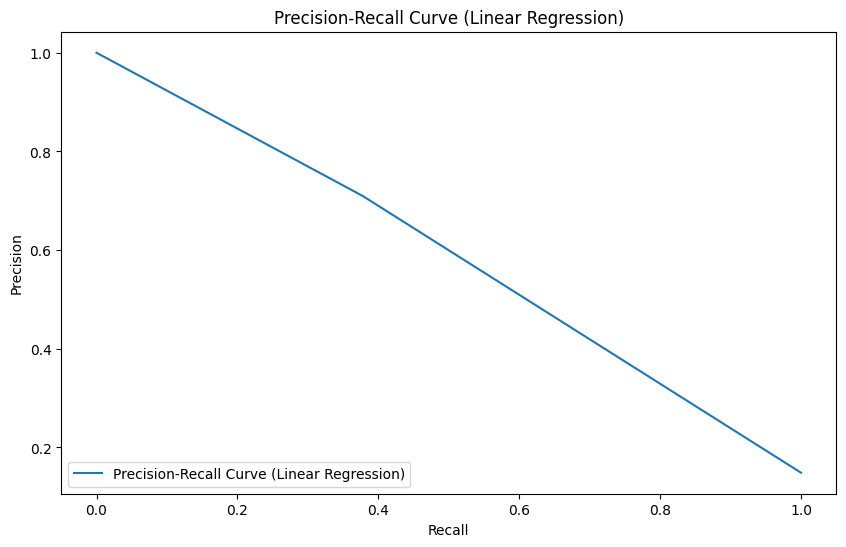

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


roc_auc_linear = roc_auc_score(y_test, y_pred_binary)
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_binary)

plt.figure(figsize=(10, 6))
plt.plot(fpr_linear, tpr_linear, label=f'ROC Curve (Linear Regression) (area = {roc_auc_linear:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Linear Regression)')
plt.legend(loc="lower right")
plt.show()


precision_linear, recall_linear, _ = precision_recall_curve(y_test, y_pred_binary)

plt.figure(figsize=(10, 6))
plt.plot(recall_linear, precision_linear, label='Precision-Recall Curve (Linear Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Linear Regression)')
plt.legend(loc="lower left")
plt.show()


# LOGISTIC REGRESSION

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [38]:

logistic_model = LogisticRegression(max_iter=1000, random_state=42)


logistic_model.fit(X_train_scaled, y_train)


y_pred_logistic = logistic_model.predict(X_test_scaled)


accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)


print(f'Accuracy (Regresión Logística): {accuracy_logistic}')
print('Confusion Matrix (Regresión Logística):')
print(cm_logistic)
print('Classification Report (Regresión Logística):')
print(report_logistic)


Accuracy (Regresión Logística): 0.8899560922063666
Confusion Matrix (Regresión Logística):
[[2995  107]
 [ 294  248]]
Classification Report (Regresión Logística):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3102
           1       0.70      0.46      0.55       542

    accuracy                           0.89      3644
   macro avg       0.80      0.71      0.75      3644
weighted avg       0.88      0.89      0.88      3644



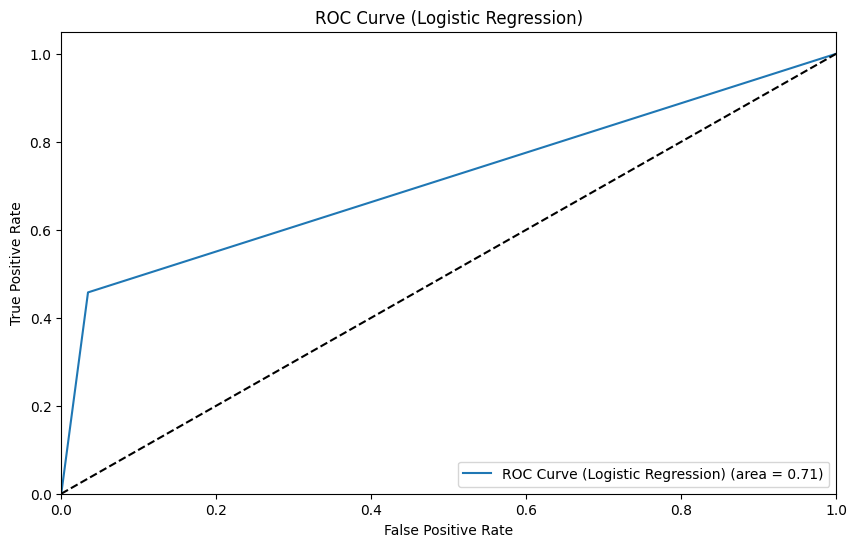

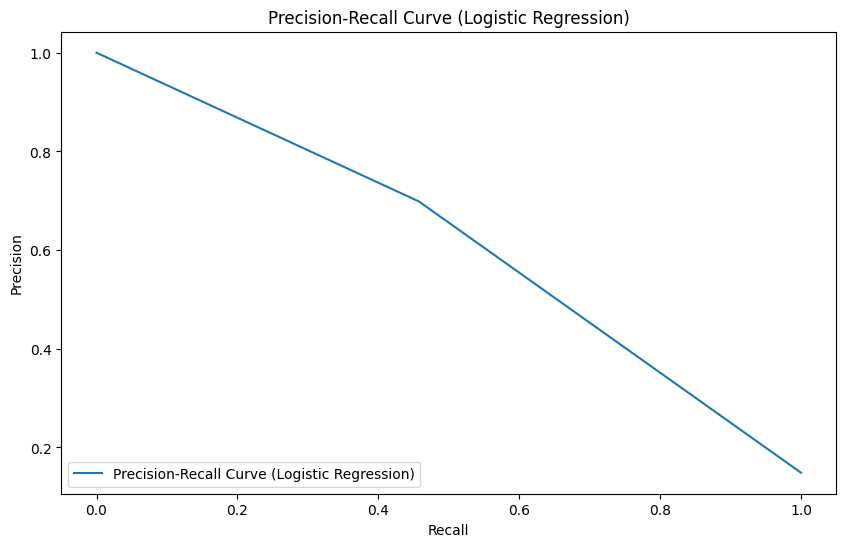

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


roc_auc_logistic = roc_auc_score(y_test, y_pred_logistic)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'ROC Curve (Logistic Regression) (area = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()


precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, y_pred_logistic)

plt.figure(figsize=(10, 6))
plt.plot(recall_logistic, precision_logistic, label='Precision-Recall Curve (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.legend(loc="lower left")
plt.show()


#  GRADIENT BOOSTING

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [41]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)


y_pred_gb = gb_model.predict(X_test_scaled)


accuracy_gb = accuracy_score(y_test, y_pred_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)


print(f'Accuracy (Gradient Boosting): {accuracy_gb}')
print('Confusion Matrix (Gradient Boosting):')
print(cm_gb)
print('Classification Report (Gradient Boosting):')
print(report_gb)


Accuracy (Gradient Boosting): 0.9020307354555434
Confusion Matrix (Gradient Boosting):
[[3018   84]
 [ 273  269]]
Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3102
           1       0.76      0.50      0.60       542

    accuracy                           0.90      3644
   macro avg       0.84      0.73      0.77      3644
weighted avg       0.89      0.90      0.89      3644



In [44]:
from sklearn.model_selection import GridSearchCV


param_grid_gb = {
    'learning_rate': [0.01, 0.1]
}


grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='accuracy')


grid_search_gb.fit(X_train_scaled, y_train)
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_scaled)


accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
cm_best_gb = confusion_matrix(y_test, y_pred_best_gb)
report_best_gb = classification_report(y_test, y_pred_best_gb)


print(f'Best Parameters (Gradient Boosting): {grid_search_gb.best_params_}')
print(f'Accuracy (Gradient Boosting): {accuracy_best_gb}')
print('Confusion Matrix (Best Gradient Boosting):')
print(cm_best_gb)
print('Classification Report (Best Gradient Boosting):')
print(report_best_gb)


Best Parameters (Gradient Boosting): {'learning_rate': 0.1}
Accuracy (Gradient Boosting): 0.9020307354555434
Confusion Matrix (Best Gradient Boosting):
[[3018   84]
 [ 273  269]]
Classification Report (Best Gradient Boosting):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3102
           1       0.76      0.50      0.60       542

    accuracy                           0.90      3644
   macro avg       0.84      0.73      0.77      3644
weighted avg       0.89      0.90      0.89      3644



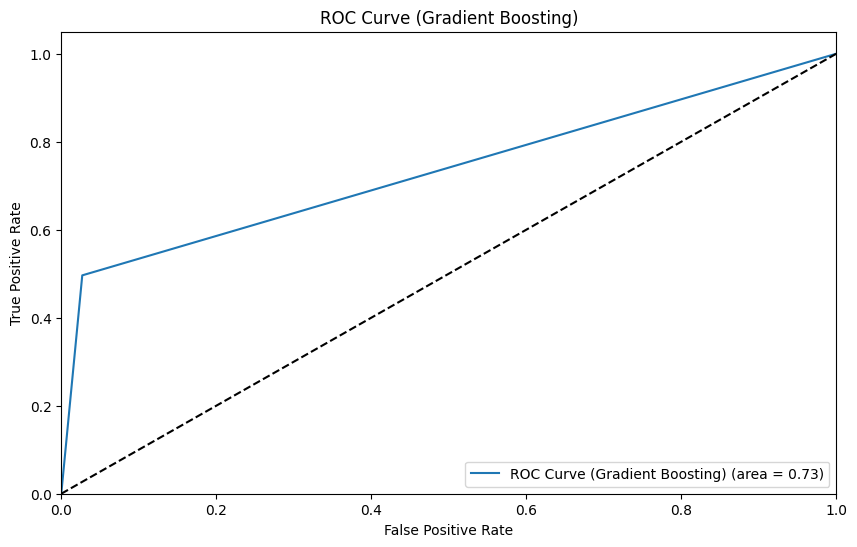

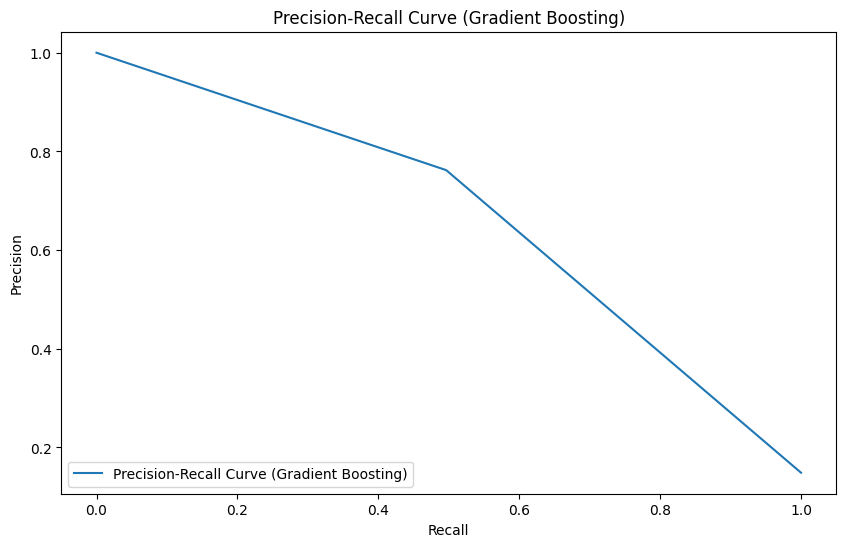

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Curva ROC
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_gb, tpr_gb, label=f'ROC Curve (Gradient Boosting) (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc="lower right")
plt.show()

# Curva Precision-Recall
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_gb)

plt.figure(figsize=(10, 6))
plt.plot(recall_gb, precision_gb, label='Precision-Recall Curve (Gradient Boosting)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Gradient Boosting)')
plt.legend(loc="lower left")
plt.show()
